In [1]:
import cv2
import random
import numpy as np
from PIL import Image
from skimage import color, filters

from lib.lime import LIME
from lib.fog_gen import generate_fog
from lib.snow_gen import SnowGenUsingNoise
from lib.gen_utils import screen_blend, layer_blend

In [2]:
class SnowEffectGenerator:
    def __init__(self):
        self._lime = LIME(iterations=25, alpha=1.0)
        self._illumination2darkness = {0: 1, 1: 0.75, 2: 0.65, 3: 0.5}
        self._weather2visibility = (500, 1000)
        self._illumination2fogcolor = {0: (80, 120), 1: (120, 160), 2: (160, 200), 3: (200, 240)}
        self._snow_layer_gen = SnowGenUsingNoise()
        
    def getIlluminationMap(self, img: np.ndarray) -> np.ndarray: 
        self._lime.load(img)
        T = self._lime.illumMap()
        return T
    
    @staticmethod
    def reduce_lightHSV(rgb, sat_red=0.5, val_red=0.5):
        hsv = color.rgb2hsv(rgb/255)
        hsv[...,1] *= sat_red
        hsv[...,2] *= val_red
        return (color.hsv2rgb(hsv)*255).astype(np.uint8)
    
    @staticmethod
    def fogAttenuation(img: np.ndarray, depth:np.ndarray, visibility=1000, fog_color=200):
        img_fog = generate_fog(img.copy(), depth.copy(), visibility=visibility, fog_color=fog_color)
        return img_fog
    
    @staticmethod
    def illumination2opacity(img: np.ndarray, illumination):
        alpha = color.rgb2gray(img)
        if illumination>0:
            alpha = np.clip(filters.gaussian((1-alpha), sigma=10, channel_axis=None),0,1)
        else:
            alpha = np.clip(2*filters.gaussian((alpha), sigma=10, channel_axis=None),0,1)
        return alpha
    
    def genSnowLayer(self, alpha):
        num_itr_small = random.randint(1,3)
        num_itr_large = random.randint(1,4)
        blur_angle = random.choice([-1, 1])*random.randint(60, 90)
        layer_small = self._snow_layer_gen.genSnowMultiLayer(h=720, 
                                                             w=1280, 
                                                             blur_angle=blur_angle,
                                                             intensity="small", 
                                                             num_itr=num_itr_small)#small
        
        layer_large = self._snow_layer_gen.genSnowMultiLayer(h=720, 
                                                             w=1280, 
                                                             blur_angle=blur_angle,
                                                             intensity="large", 
                                                             num_itr=num_itr_large)#large
        layer = layer_blend(layer_small, layer_large)
        return (layer.astype(float)*alpha).astype(np.uint8)
    
    def genEffect(self, img_path: str, depth_path: str):
        I = np.array(Image.open(img_path))
        D = np.load(depth_path)
        
        T = self.getIlluminationMap(I)
        illumination_array = np.histogram(T, bins=4, range=(0,1))[0]/(T.size)
        illumination = illumination_array.argmax()
        
        if illumination>0:
            visibility = random.randint(self._weather2visibility[0], self._weather2visibility[1])
            fog_color = random.randint(self._illumination2fogcolor[illumination][0], self._illumination2fogcolor[illumination][1])
            I_dark = self.reduce_lightHSV(I, sat_red=self._illumination2darkness[illumination], val_red=self._illumination2darkness[illumination])
            I_fog = self.fogAttenuation(I_dark, D, visibility=visibility, fog_color=fog_color)
        else:
            fog_color = 75
            visibility = D.max()*0.75 if D.max()<1000 else 750
            I_fog = self.fogAttenuation(I, D, visibility=visibility, fog_color=fog_color)
        
        alpha = self.illumination2opacity(I, illumination)
        snow_layer = self.genSnowLayer(alpha)
        I_snow = screen_blend(I_fog, snow_layer)
        return I_snow

In [3]:
snowgen = SnowEffectGenerator()

In [ ]:
save_folder = "../../dataset/train/snow_synthetic/images"
depth_folder = "snow_depth"

with open("snow_list.txt", "r") as f:
    content_files = f.read().splitlines() 
content_files = [Path(p) for p in content_files]

for path in tqdm(content_files):
    snowy = snowgen.genEffect(path, os.path.join(depth_folder, path.stem+".npy"))
    Image.fromarray(foggy.astype(np.uint8)).save(os.path.join(save_folder, path.stem+"_ssyn.jpg"))

In [4]:
img_name = "b1cd1e94-26dd524f"
image_path = f"data/rgb/{img_name}.jpg"
depth_path = f"data/depth/{img_name}.npy"
disp_path = "b1c66a42-6f7d68ca_disp.png"

In [5]:
I_snow = we.genEffect(img_path=image_path, depth_path=depth_path)

100%|███████████████████████████████████████████| 25/25 [00:09<00:00,  2.62it/s]


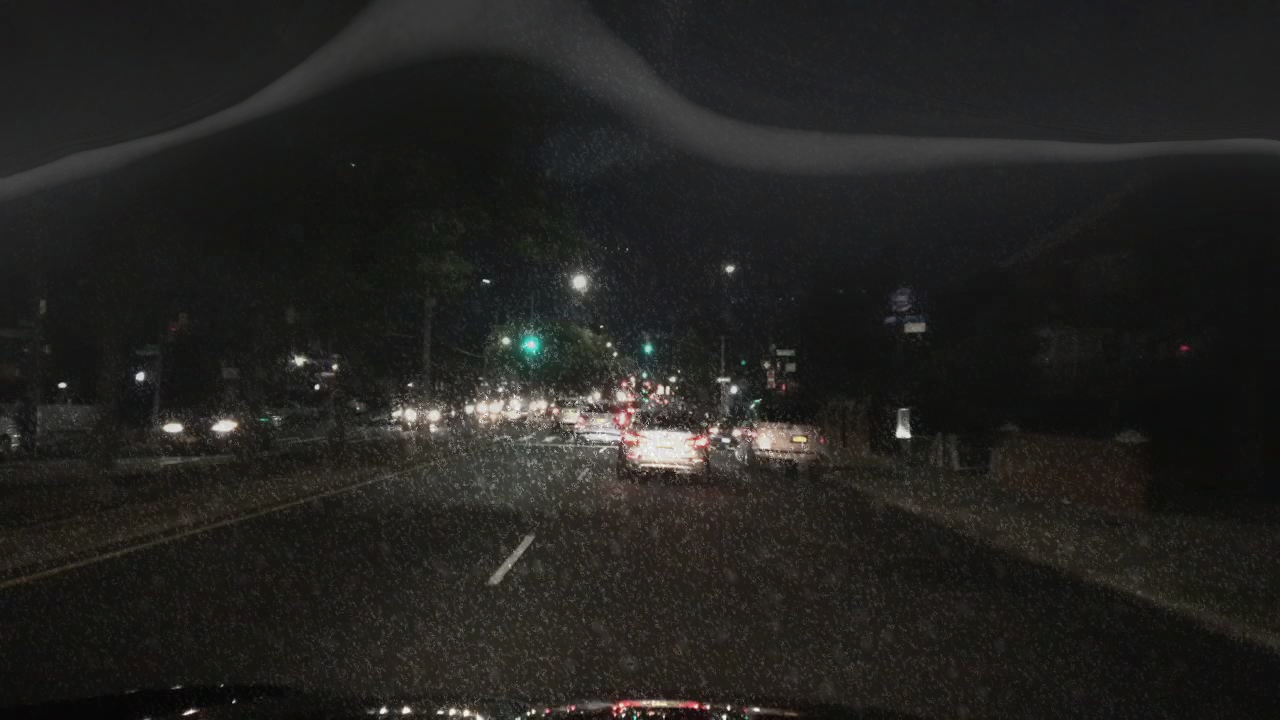

In [6]:
Image.fromarray(I_snow)